In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
import itertools
import logging
import math
import os
import time as tm

import torch
import torch.distributions.constraints as constraints
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import sys

import pyro
from pyro.contrib.easyguide import easy_guide
from pyro.optim import Adam
import pyro.optim
import pyro.infer
import pyro.distributions as dist
import pyro.contrib.autoguide as autoguide
from pyro.infer import SVI, Trace_ELBO

In [156]:
from models import *
from svi_funcs import *
from utils import *

In [99]:
raw_df = pd.read_csv('data_sets/GSE154112_Three-way_ovarian_cancer_gRNA_screen_count_per_million_reads.csv', header=1).fillna(0)

n_genes = 16
n_guides = 32

# Run some cleanup on in the input data
raw_df[['g1', 'g2', 'g3']] = raw_df['Key'].str.split(',', expand=True).astype(int)  # Expand the 'Key' column from a comma-separated string into its constitute guide index parts
sko_index_mapping_dict = pd.Series((raw_df['mU6 (P3)']).values, index=(raw_df['g1'] - 1)).to_dict()  # Build a map from guide indices to guide names

# Generate log2 fold-changes from D15 to D26 and store as a torch.tensor
lfcs = torch.tensor(np.log2(list((raw_df['Cell_D26_rep1'] + raw_df['Cell_D26_rep2']) / 2.0 + 1.0))
                    - np.log2(list((raw_df['Cell_D15_rep1'] + raw_df['Cell_D15_rep2']) / 2.0 + 1.0)))

# Store guide indices as a torch.tensor
sko_ind_mat = torch.tensor(raw_df['Key'].str.get_dummies(',').T.values).type(torch.FloatTensor)
dko_ind_mat = build_dko_indicator_matrix(n_guides)
tko_ind_mat = build_tko_indicator_matrix(n_guides)

dko_index_mapping_dict = build_dko_index_mapping_dict(sko_index_mapping_dict)
tko_index_mapping_dict = build_tko_index_mapping_dict(sko_index_mapping_dict)

outputs_dict = {}

step:    49, ELBO loss: 40020.54
step:    99, ELBO loss: 38516.89
step:   149, ELBO loss: 38401.60
step:   199, ELBO loss: 38234.11
step:   249, ELBO loss: 37954.38

finished in 3.23 seconds


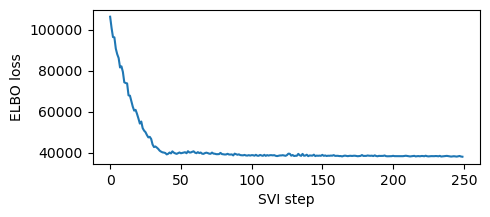

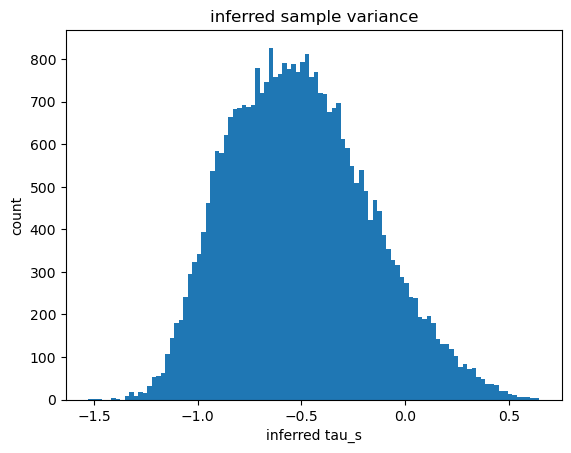

In [100]:
# Single mu for each guide

sko_ind_mat = torch.tensor(raw_df['Key'].str.get_dummies(',').T.values).type(torch.FloatTensor)

model = sko_model
model_args = (sko_ind_mat, lfcs)
model_name = 'sko_model'

outputs_dict[model_name] = {}

images_path = f"images/{model_name}"
outputs_path = f"outputs/{model_name}"

if not os.path.exists(images_path):
    os.makedirs(images_path)
if not os.path.exists(outputs_path):
    os.makedirs(outputs_path)

pyro.render_model(model, model_args=model_args, render_distributions=True, filename=f"{images_path}/{model_name}_plate-notation.png")

guide = pyro.infer.autoguide.AutoNormal(model)
losses, params = run_svi(model, model_args, guide)

plt.figure(figsize=(5, 2))
plt.plot(losses.values())
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

plt.savefig(f"{images_path}/{model_name}_elbo.png", dpi=300, bbox_inches='tight')
plt.show()

outputs_dict[model_name]['losses'] = losses
outputs_dict[model_name]['params'] = get_params_dict(params)
outputs_dict[model_name]['effects'] = get_effects_df(outputs_dict[model_name]['params'], sko_index_mapping_dict, n_guides)

graph_inferred_mus(outputs_dict[model_name]['effects'], model_name, images_path)
graph_inferred_taus(outputs_dict[model_name]['params'], model_name, images_path)

graph_variational_distributions(outputs_dict[model_name]['effects'], model_name, images_path)

In [101]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
svi_samples = predictive(sko_ind_mat, lfcs=None)
svi_lfcs = svi_samples['y_s'].squeeze(1)

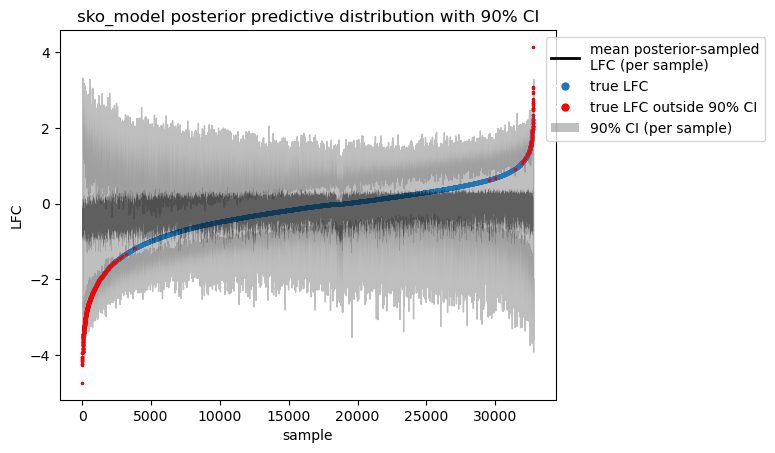

In [102]:
lfc_predictions = pd.DataFrame({
    "sample_index": range(0, lfcs.shape[0]),
    "y_mean": svi_lfcs.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_lfcs": lfcs,
}).sort_values(by='true_lfcs')
lfc_predictions.index = range(0, lfcs.shape[0])

outputs_dict[model_name]['predictions'] = lfc_predictions

outside_ci = lfc_predictions[(lfc_predictions['true_lfcs'] < lfc_predictions['y_perc_5']) | (lfc_predictions['true_lfcs'] > lfc_predictions['y_perc_95'])]

plt.fill_between(lfc_predictions['y_perc_5'].index, lfc_predictions['y_perc_5'], lfc_predictions['y_perc_95'], alpha=0.5, color='grey')
plt.plot(lfc_predictions['y_mean'].index, lfc_predictions['y_mean'].values, color='k',linewidth=0.1, alpha=0.5)
plt.scatter(lfc_predictions['true_lfcs'].index, lfc_predictions['true_lfcs'].values, s=2)
plt.scatter(outside_ci.index, outside_ci['true_lfcs'], color='red', s=2)

plt.title(f"{model_name} posterior predictive distribution with 90% CI")
plt.xlabel('sample')
plt.ylabel('LFC')

legend_elements = [Line2D([0], [0], color='k', lw=2, label='mean posterior-sampled\nLFC (per sample)'),
                   Line2D([0], [0], marker='o', color='w', label='true LFC', markerfacecolor='#1f77b4', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='true LFC outside 90% CI', markerfacecolor='red', markersize=7),
                   Patch(facecolor='grey', alpha=0.5, label='90% CI (per sample)')]
plt.legend(handles=legend_elements, loc=(0.98, 0.7))

plt.savefig(f"{images_path}/{model_name}_posterior-predictions_vs_true_lfcs.png", dpi=300, bbox_inches='tight')

plt.show()

step:    49, ELBO loss: 42797.19
step:    99, ELBO loss: 40911.20
step:   149, ELBO loss: 39758.75
step:   199, ELBO loss: 39943.82
step:   249, ELBO loss: 39521.79

finished in 6.99 seconds


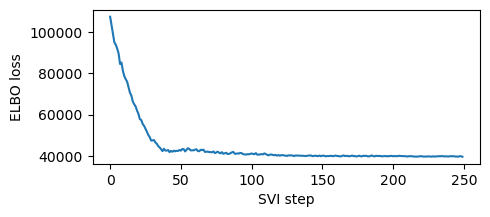

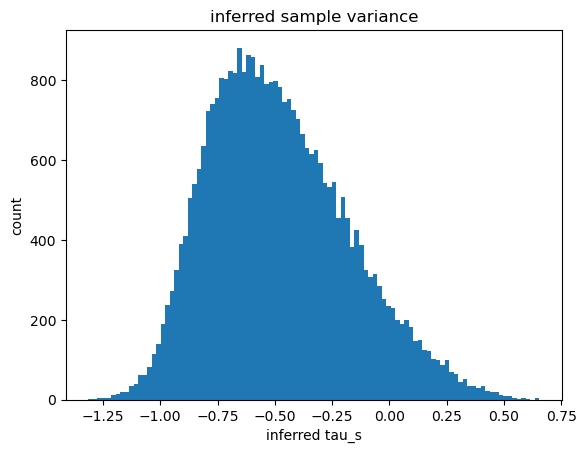

In [103]:
# Single mu for each guide, double mu for each DKO 

sko_ind_mat = torch.tensor(raw_df['Key'].str.get_dummies(',').T.values).type(torch.FloatTensor)
dko_ind_mat = build_dko_indicator_matrix(n_guides)

model = sko_dko_model
model_args = (sko_ind_mat, dko_ind_mat, lfcs)
model_name = 'sko_dko_model'

outputs_dict[model_name] = {}

images_path = f"images/{model_name}"
outputs_path = f"outputs/{model_name}"

if not os.path.exists(images_path):
    os.makedirs(images_path)
if not os.path.exists(outputs_path):
    os.makedirs(outputs_path)

pyro.render_model(model, model_args=model_args, render_distributions=True, filename=f"{images_path}/{model_name}_plate-notation.pdf")

guide = pyro.infer.autoguide.AutoNormal(model)
losses, params = run_svi(model, model_args, guide)

plt.figure(figsize=(5, 2))
plt.plot(losses.values())
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

plt.savefig(f"{images_path}/{model_name}_elbo.png", dpi=300, bbox_inches='tight')
plt.show()

outputs_dict[model_name]['losses'] = losses
outputs_dict[model_name]['params'] = get_params_dict(params)
outputs_dict[model_name]['effects'] = get_effects_df(outputs_dict[model_name]['params'], sko_index_mapping_dict, n_guides)

graph_inferred_mus(outputs_dict[model_name]['effects'], model_name, images_path)
graph_inferred_taus(outputs_dict[model_name]['params'], model_name, images_path)

graph_variational_distributions(outputs_dict[model_name]['effects'], model_name, images_path)

In [104]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
svi_samples = predictive(sko_ind_mat, dko_ind_mat, lfcs=None)
svi_lfcs = svi_samples['y_s'].squeeze(1)

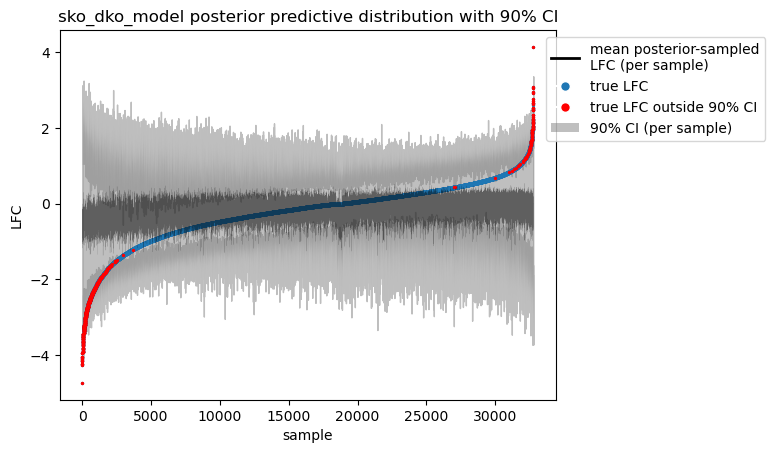

In [105]:
lfc_predictions = pd.DataFrame({
    "sample_index": range(0, lfcs.shape[0]),
    "y_mean": svi_lfcs.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_lfcs": lfcs,
}).sort_values(by='true_lfcs')
lfc_predictions.index = range(0, lfcs.shape[0])

outputs_dict[model_name]['predictions'] = lfc_predictions

outside_ci = lfc_predictions[(lfc_predictions['true_lfcs'] < lfc_predictions['y_perc_5']) | (lfc_predictions['true_lfcs'] > lfc_predictions['y_perc_95'])]

plt.fill_between(lfc_predictions['y_perc_5'].index, lfc_predictions['y_perc_5'], lfc_predictions['y_perc_95'], alpha=0.5, color='grey')
plt.plot(lfc_predictions['y_mean'].index, lfc_predictions['y_mean'].values, color='k',linewidth=0.1, alpha=0.5)
plt.scatter(lfc_predictions['true_lfcs'].index, lfc_predictions['true_lfcs'].values, s=2)
plt.scatter(outside_ci.index, outside_ci['true_lfcs'], color='red', s=2)

plt.title(f"{model_name} posterior predictive distribution with 90% CI")
plt.xlabel('sample')
plt.ylabel('LFC')

legend_elements = [Line2D([0], [0], color='k', lw=2, label='mean posterior-sampled\nLFC (per sample)'),
                   Line2D([0], [0], marker='o', color='w', label='true LFC', markerfacecolor='#1f77b4', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='true LFC outside 90% CI', markerfacecolor='red', markersize=7),
                   Patch(facecolor='grey', alpha=0.5, label='90% CI (per sample)')]
plt.legend(handles=legend_elements, loc=(0.98, 0.7))

plt.savefig(f"{images_path}/{model_name}_posterior-predictions_vs_true_lfcs.png", dpi=300, bbox_inches='tight')

plt.show()

step:    49, ELBO loss: 46739.90
step:    99, ELBO loss: 45581.68
step:   149, ELBO loss: 44875.44
step:   199, ELBO loss: 44471.16
step:   249, ELBO loss: 44145.77

finished in 26.53 seconds


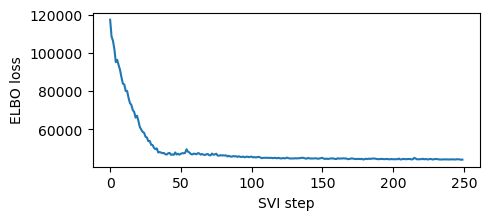

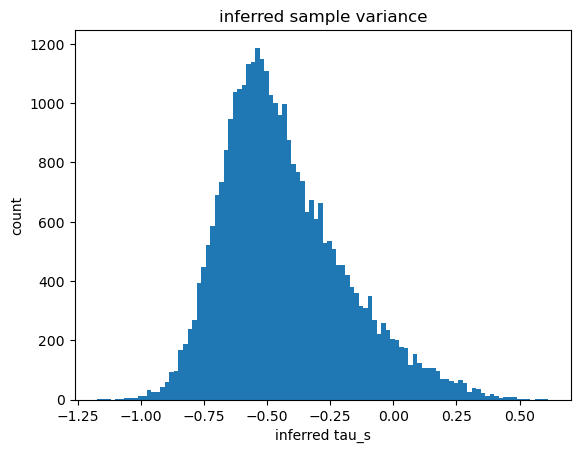

In [106]:
# Single mu for each guide, triple mu for each TKO 

sko_ind_mat = torch.tensor(raw_df['Key'].str.get_dummies(',').T.values).type(torch.FloatTensor)
tko_ind_mat = build_tko_indicator_matrix(n_guides)

model = sko_tko_model
model_args = (sko_ind_mat, tko_ind_mat, lfcs)
model_name = 'sko_tko_model'

outputs_dict[model_name] = {}

images_path = f"images/{model_name}"
outputs_path = f"outputs/{model_name}"

if not os.path.exists(images_path):
    os.makedirs(images_path)
if not os.path.exists(outputs_path):
    os.makedirs(outputs_path)

pyro.render_model(model, model_args=model_args, render_distributions=True, filename=f"{images_path}/{model_name}_plate-notation.png")

guide = pyro.infer.autoguide.AutoNormal(model)
losses, params = run_svi(model, model_args, guide)

plt.figure(figsize=(5, 2))
plt.plot(losses.values())
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

plt.savefig(f"{images_path}/{model_name}_elbo.png", dpi=300, bbox_inches='tight')
plt.show()

outputs_dict[model_name]['losses'] = losses
outputs_dict[model_name]['params'] = get_params_dict(params)
outputs_dict[model_name]['effects'] = get_effects_df(outputs_dict[model_name]['params'], sko_index_mapping_dict, n_guides)

graph_inferred_mus(outputs_dict[model_name]['effects'], model_name, images_path)
graph_inferred_taus(outputs_dict[model_name]['params'], model_name, images_path)

graph_variational_distributions(outputs_dict[model_name]['effects'], model_name, images_path)

In [107]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
svi_samples = predictive(sko_ind_mat, tko_ind_mat, lfcs=None)
svi_lfcs = svi_samples['y_s'].squeeze(1)

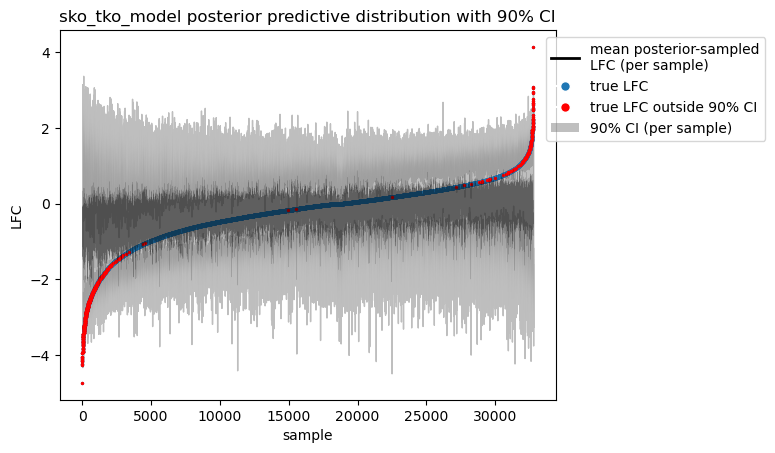

In [108]:
lfc_predictions = pd.DataFrame({
    "sample_index": range(0, lfcs.shape[0]),
    "y_mean": svi_lfcs.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_lfcs": lfcs,
}).sort_values(by='true_lfcs')
lfc_predictions.index = range(0, lfcs.shape[0])

outputs_dict[model_name]['predictions'] = lfc_predictions

outside_ci = lfc_predictions[(lfc_predictions['true_lfcs'] < lfc_predictions['y_perc_5']) | (lfc_predictions['true_lfcs'] > lfc_predictions['y_perc_95'])]

plt.fill_between(lfc_predictions['y_perc_5'].index, lfc_predictions['y_perc_5'], lfc_predictions['y_perc_95'], alpha=0.5, color='grey')
plt.plot(lfc_predictions['y_mean'].index, lfc_predictions['y_mean'].values, color='k',linewidth=0.1, alpha=0.5)
plt.scatter(lfc_predictions['true_lfcs'].index, lfc_predictions['true_lfcs'].values, s=2)
plt.scatter(outside_ci.index, outside_ci['true_lfcs'], color='red', s=2)

plt.title(f"{model_name} posterior predictive distribution with 90% CI")
plt.xlabel('sample')
plt.ylabel('LFC')

legend_elements = [Line2D([0], [0], color='k', lw=2, label='mean posterior-sampled\nLFC (per sample)'),
                   Line2D([0], [0], marker='o', color='w', label='true LFC', markerfacecolor='#1f77b4', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='true LFC outside 90% CI', markerfacecolor='red', markersize=7),
                   Patch(facecolor='grey', alpha=0.5, label='90% CI (per sample)')]
plt.legend(handles=legend_elements, loc=(0.98, 0.7))

plt.savefig(f"{images_path}/{model_name}_posterior-predictions_vs_true_lfcs.png", dpi=300, bbox_inches='tight')

plt.show()

step:    49, ELBO loss: 48091.36
step:    99, ELBO loss: 46783.72
step:   149, ELBO loss: 46193.14
step:   199, ELBO loss: 46087.72
step:   249, ELBO loss: 45696.04

finished in 28.60 seconds


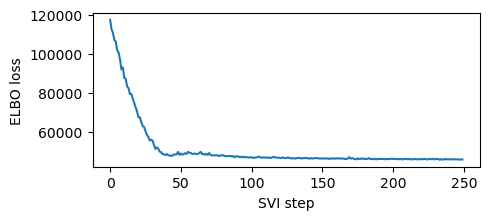

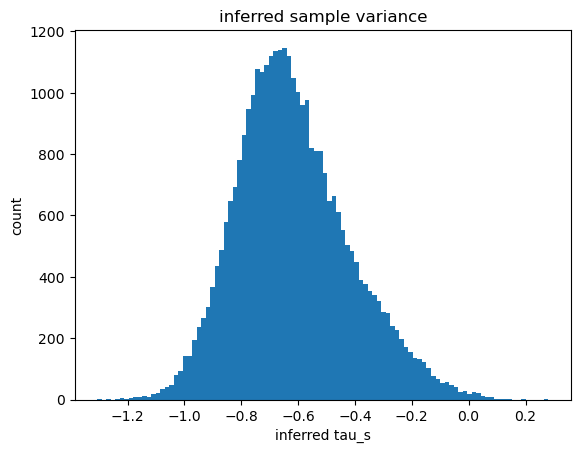

In [109]:
# Single mu for each guide, double mu for each DKO, triple mu for each TKO 

sko_ind_mat = torch.tensor(raw_df['Key'].str.get_dummies(',').T.values).type(torch.FloatTensor)
dko_ind_mat = build_dko_indicator_matrix(32)
tko_ind_mat = build_tko_indicator_matrix(32)

model = sko_dko_tko_model
model_args = (sko_ind_mat, dko_ind_mat, tko_ind_mat, lfcs)
model_name = 'sko_dko_tko_model'

outputs_dict[model_name] = {}

images_path = f"images/{model_name}"
outputs_path = f"outputs/{model_name}"

if not os.path.exists(images_path):
    os.makedirs(images_path)
if not os.path.exists(outputs_path):
    os.makedirs(outputs_path)

pyro.render_model(model, model_args=model_args, render_distributions=True, filename=f"{images_path}/{model_name}_plate-notation.png")

guide = pyro.infer.autoguide.AutoNormal(model)
losses, params = run_svi(model, model_args, guide)

plt.figure(figsize=(5, 2))
plt.plot(losses.values())
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

plt.savefig(f"{images_path}/{model_name}_elbo.png", dpi=300, bbox_inches='tight')
plt.show()

outputs_dict[model_name]['losses'] = losses
outputs_dict[model_name]['params'] = get_params_dict(params)
outputs_dict[model_name]['effects'] = get_effects_df(outputs_dict[model_name]['params'], sko_index_mapping_dict, n_guides)

graph_inferred_mus(outputs_dict[model_name]['effects'], model_name, images_path)
graph_inferred_taus(outputs_dict[model_name]['params'], model_name, images_path)

graph_variational_distributions(outputs_dict[model_name]['effects'], model_name, images_path)

In [110]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
svi_samples = predictive(sko_ind_mat, dko_ind_mat, tko_ind_mat, lfcs=None)
svi_lfcs = svi_samples['y_s'].squeeze(1)

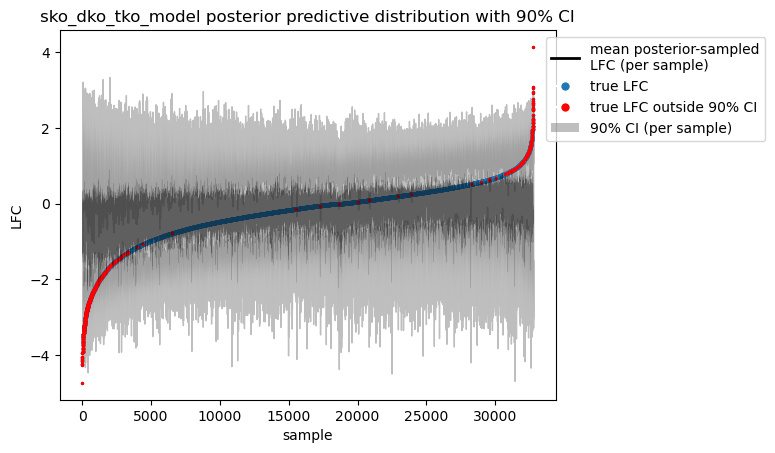

In [111]:
lfc_predictions = pd.DataFrame({
    "sample_index": range(0, lfcs.shape[0]),
    "y_mean": svi_lfcs.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_lfcs": lfcs,
}).sort_values(by='true_lfcs')
lfc_predictions.index = range(0, lfcs.shape[0])

outputs_dict[model_name]['predictions'] = lfc_predictions

outside_ci = lfc_predictions[(lfc_predictions['true_lfcs'] < lfc_predictions['y_perc_5']) | (lfc_predictions['true_lfcs'] > lfc_predictions['y_perc_95'])]

plt.fill_between(lfc_predictions['y_perc_5'].index, lfc_predictions['y_perc_5'], lfc_predictions['y_perc_95'], alpha=0.5, color='grey')
plt.plot(lfc_predictions['y_mean'].index, lfc_predictions['y_mean'].values, color='k',linewidth=0.1, alpha=0.5)
plt.scatter(lfc_predictions['true_lfcs'].index, lfc_predictions['true_lfcs'].values, s=2)
plt.scatter(outside_ci.index, outside_ci['true_lfcs'], color='red', s=2)

plt.title(f"{model_name} posterior predictive distribution with 90% CI")
plt.xlabel('sample')
plt.ylabel('LFC')

legend_elements = [Line2D([0], [0], color='k', lw=2, label='mean posterior-sampled\nLFC (per sample)'),
                   Line2D([0], [0], marker='o', color='w', label='true LFC', markerfacecolor='#1f77b4', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='true LFC outside 90% CI', markerfacecolor='red', markersize=7),
                   Patch(facecolor='grey', alpha=0.5, label='90% CI (per sample)')]
plt.legend(handles=legend_elements, loc=(0.98, 0.7))

plt.savefig(f"{images_path}/{model_name}_posterior-predictions_vs_true_lfcs.png", dpi=300, bbox_inches='tight')

plt.show()

In [77]:
# DNMT1 + POLA1 + EGFR or ERBB2
# CDK4 + MAP2K1+ POLA1

In [179]:
outputs_dict['sko_dko_tko_guide_gene_model']['effects'] = get_effects_df(outputs_dict['sko_dko_tko_guide_gene_model']['params'], sko_index_mapping_dict, n_guides)


step:    49, ELBO loss: 50589.15
step:    99, ELBO loss: 48314.18
step:   149, ELBO loss: 47771.16
step:   199, ELBO loss: 47629.86
step:   249, ELBO loss: 47533.10

finished in 318.30 seconds


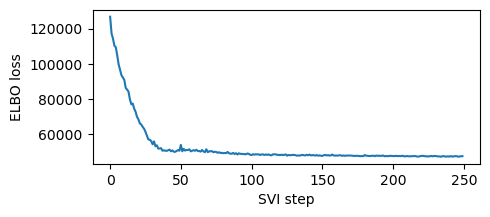

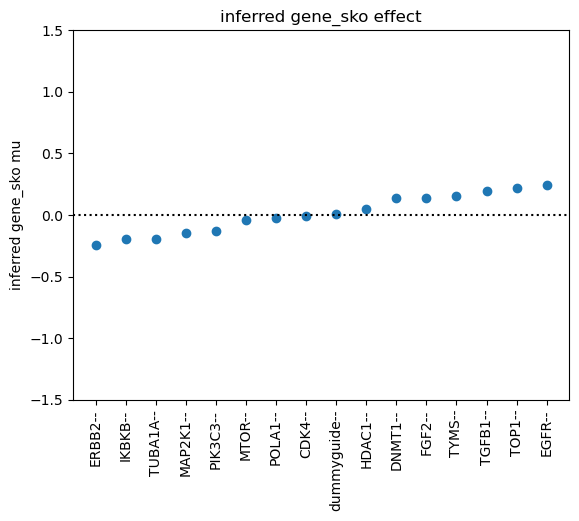

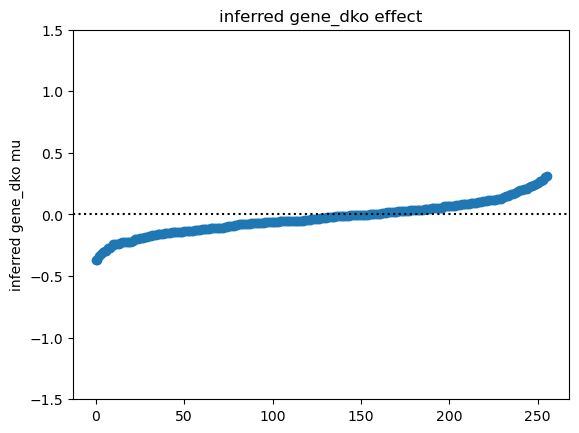

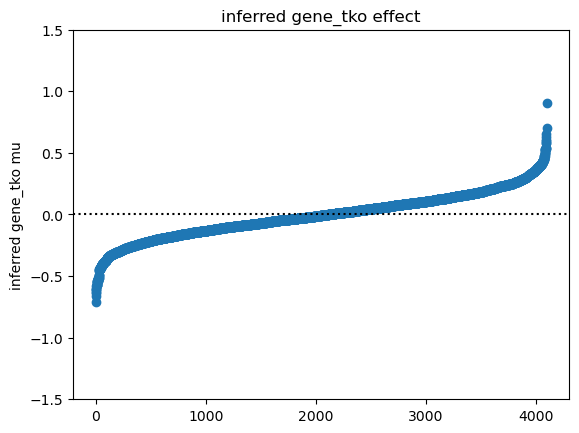

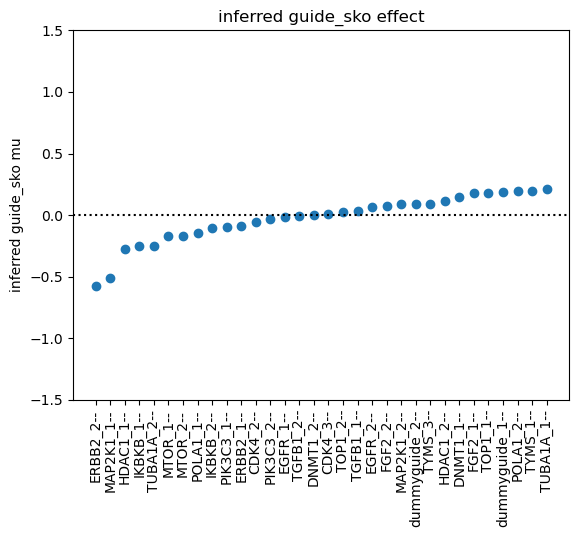

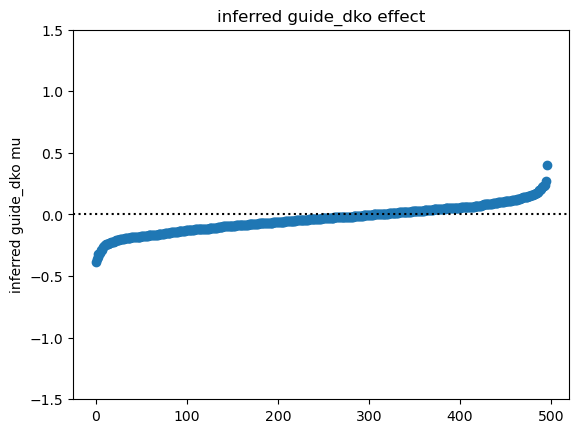

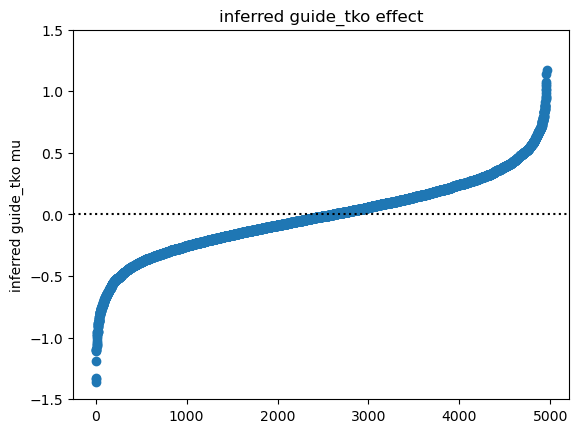

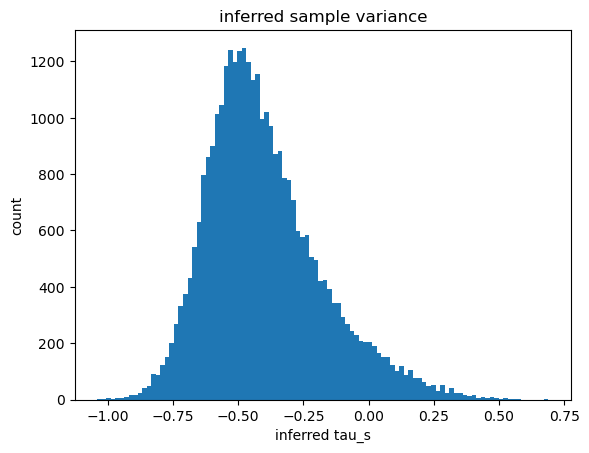

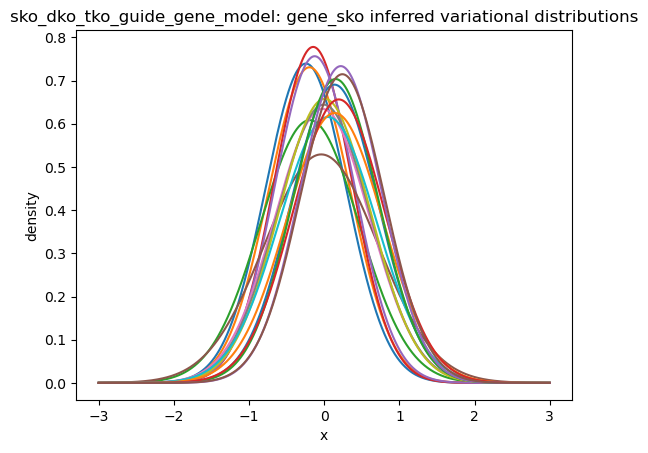

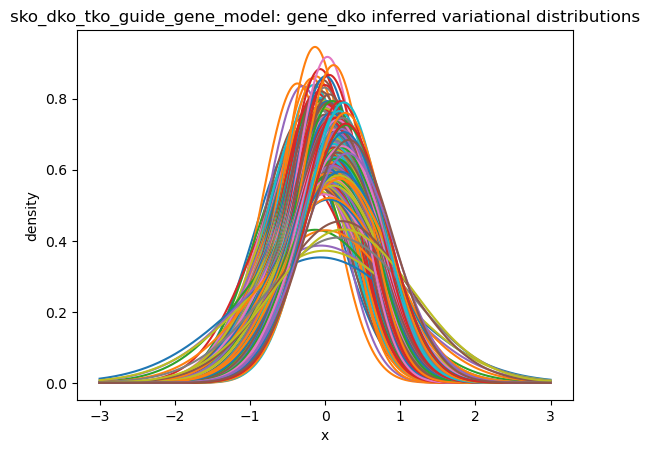

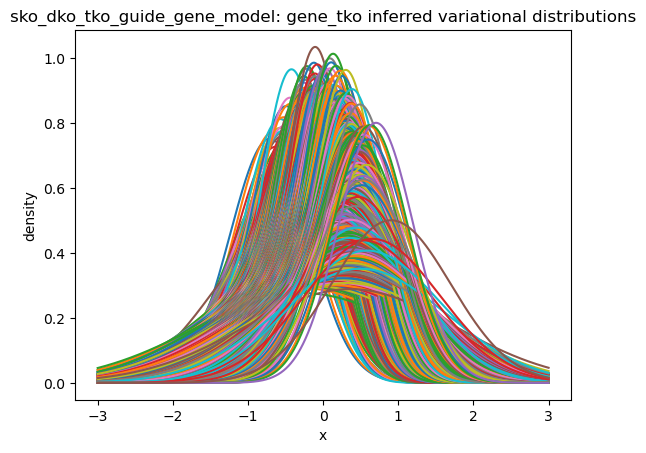

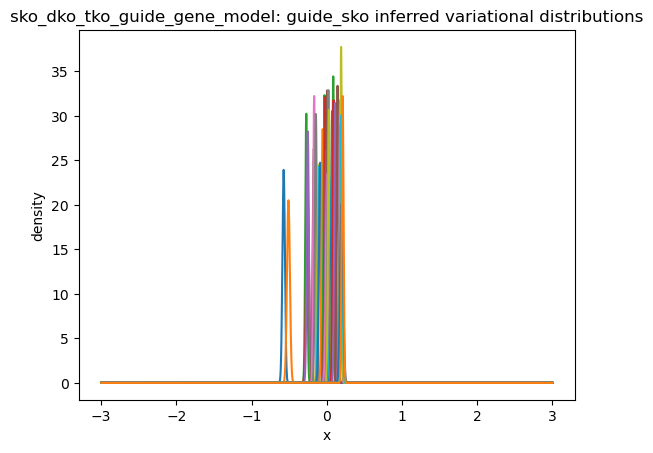

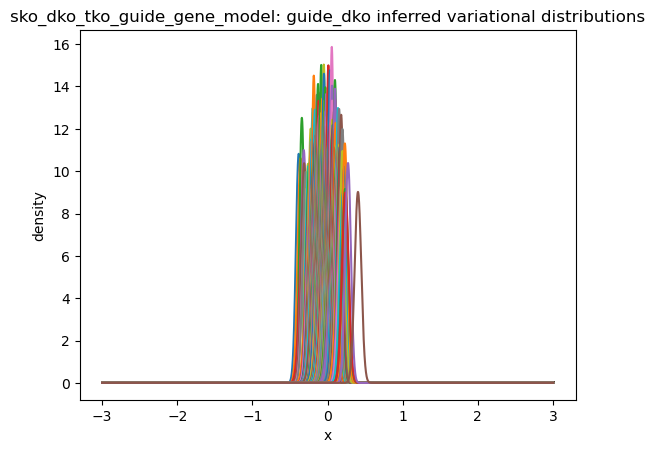

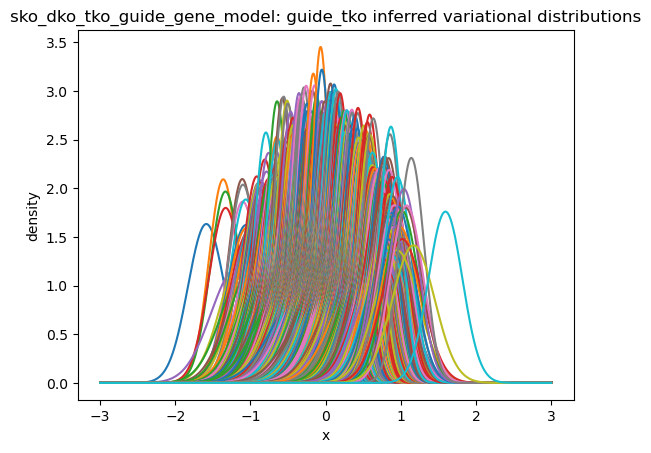

In [195]:
# Single mu for each guide, double mu for each DKO, triple mu for each TKO, all influenced by gene-specific SKO, DKO, and TKO effects

model = sko_dko_tko_guide_gene_model
model_args = (sko_ind_mat, dko_ind_mat, tko_ind_mat, n_genes, lfcs)
model_name = 'sko_dko_tko_guide_gene_model'

outputs_dict[model_name] = {}

images_path = f"images/{model_name}"
outputs_path = f"outputs/{model_name}"

if not os.path.exists(images_path):
    os.makedirs(images_path)
if not os.path.exists(outputs_path):
    os.makedirs(outputs_path)

pyro.render_model(model, model_args=model_args, render_distributions=True, filename=f"{images_path}/{model_name}_plate-notation.png")

guide = pyro.infer.autoguide.AutoNormal(model)
losses, params = run_svi(model, model_args, guide)

plt.figure(figsize=(5, 2))
plt.plot(losses.values())
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

plt.savefig(f"{images_path}/{model_name}_elbo.png", dpi=300, bbox_inches='tight')
plt.show()

outputs_dict[model_name]['losses'] = losses
outputs_dict[model_name]['params'] = get_params_dict(params)
outputs_dict[model_name]['effects'] = get_effects_df(outputs_dict[model_name]['params'], sko_index_mapping_dict, n_guides)

graph_inferred_mus(outputs_dict[model_name]['effects'], model_name, images_path)
graph_inferred_taus(outputs_dict[model_name]['params'], model_name, images_path)

graph_variational_distributions(outputs_dict[model_name]['effects'], model_name, images_path)

In [196]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
svi_samples = predictive(sko_ind_mat, dko_ind_mat, tko_ind_mat, n_genes, lfcs=None)
svi_lfcs = svi_samples['y_s'].squeeze(1)

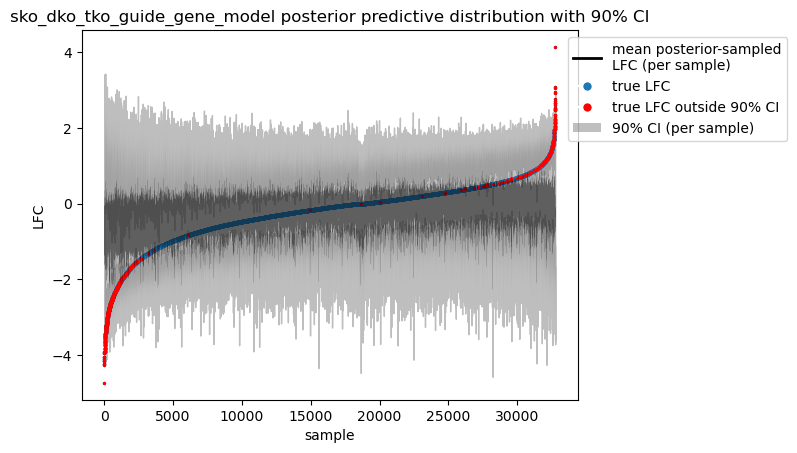

In [197]:
lfc_predictions = pd.DataFrame({
    "sample_index": range(0, lfcs.shape[0]),
    "y_mean": svi_lfcs.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_lfcs.kthvalue(int(len(svi_lfcs) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_lfcs": lfcs,
}).sort_values(by='true_lfcs')
lfc_predictions.index = range(0, lfcs.shape[0])

outputs_dict[model_name]['predictions'] = lfc_predictions

outside_ci = lfc_predictions[(lfc_predictions['true_lfcs'] < lfc_predictions['y_perc_5']) | (lfc_predictions['true_lfcs'] > lfc_predictions['y_perc_95'])]

plt.fill_between(lfc_predictions['y_perc_5'].index, lfc_predictions['y_perc_5'], lfc_predictions['y_perc_95'], alpha=0.5, color='grey')
plt.plot(lfc_predictions['y_mean'].index, lfc_predictions['y_mean'].values, color='k',linewidth=0.1, alpha=0.5)
plt.scatter(lfc_predictions['true_lfcs'].index, lfc_predictions['true_lfcs'].values, s=2)
plt.scatter(outside_ci.index, outside_ci['true_lfcs'], color='red', s=2)

plt.title(f"{model_name} posterior predictive distribution with 90% CI")
plt.xlabel('sample')
plt.ylabel('LFC')

legend_elements = [Line2D([0], [0], color='k', lw=2, label='mean posterior-sampled\nLFC (per sample)'),
                   Line2D([0], [0], marker='o', color='w', label='true LFC', markerfacecolor='#1f77b4', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='true LFC outside 90% CI', markerfacecolor='red', markersize=7),
                   Patch(facecolor='grey', alpha=0.5, label='90% CI (per sample)')]
plt.legend(handles=legend_elements, loc=(0.98, 0.7))

plt.savefig(f"{images_path}/{model_name}_posterior-predictions_vs_true_lfcs.png", dpi=300, bbox_inches='tight')

plt.show()

In [201]:
# DNMT1 + POLA1 + EGFR or ERBB2
# CDK4 + MAP2K1+ POLA1

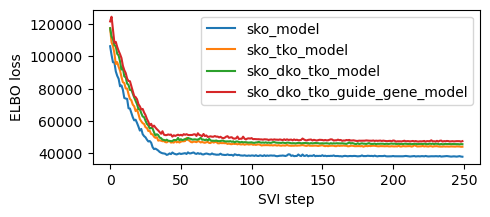

In [121]:
plt.figure(figsize=(5, 2))

for model_name in outputs_dict:
    
    if model_name == 'sko_dko_model':
        continue
    
    losses = outputs_dict[model_name]['losses']
    plt.plot(losses.values(), label=model_name)
    
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

plt.legend()

plt.savefig(f"images/all_models_elbo.png", dpi=300, bbox_inches='tight')
plt.show()

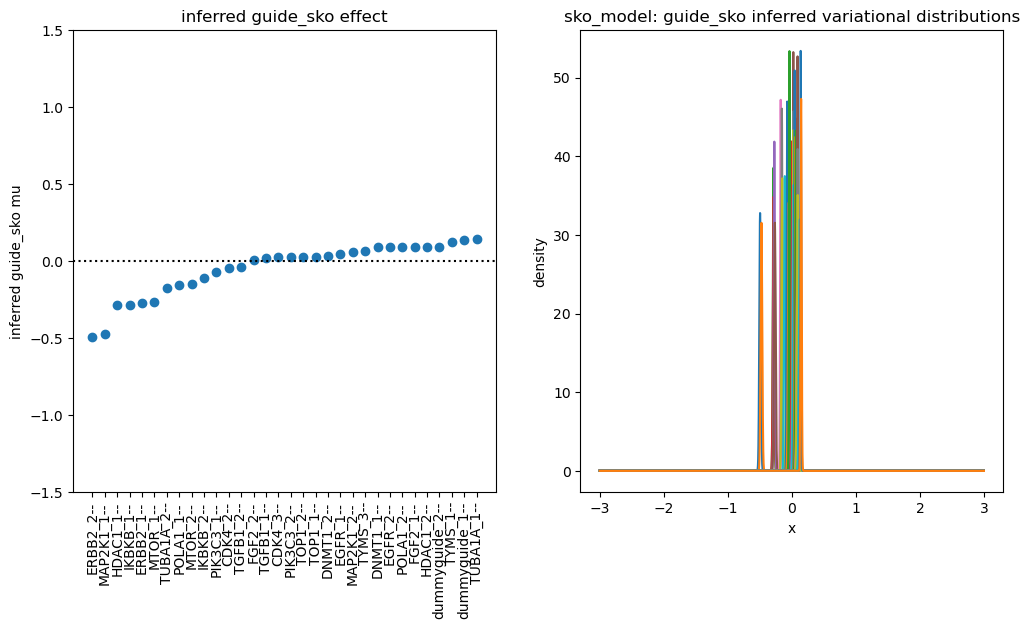

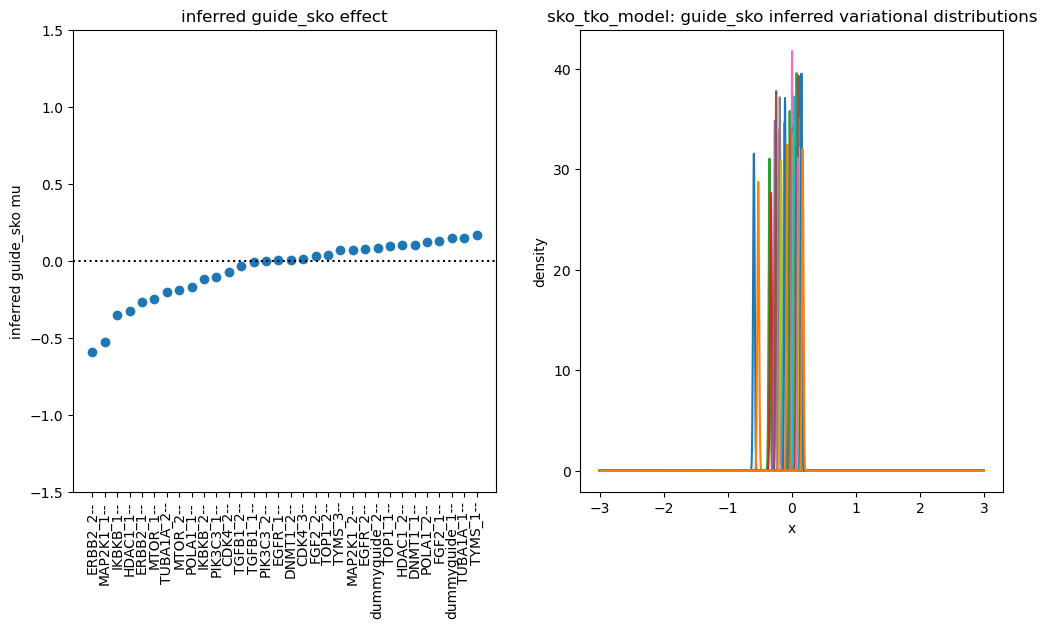

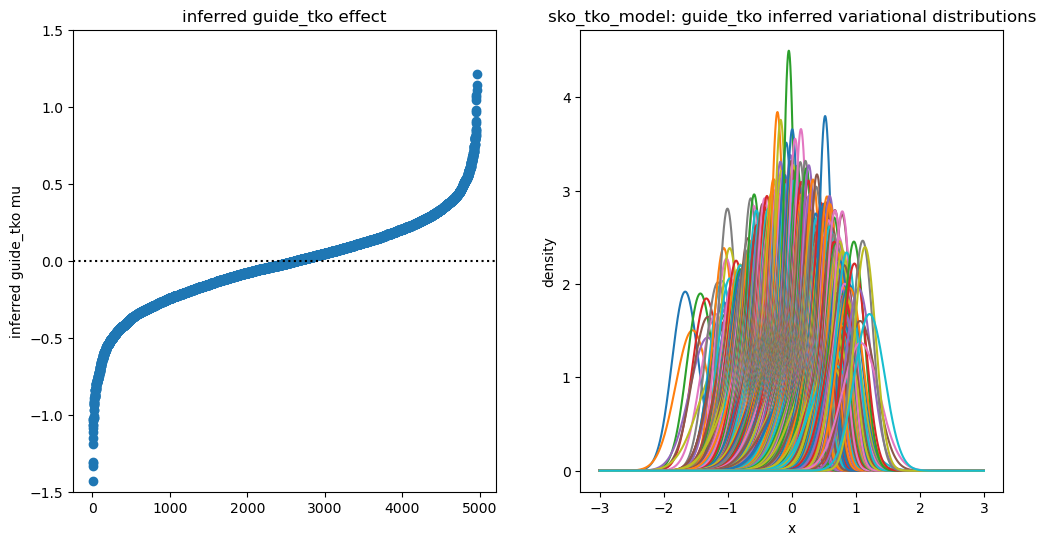

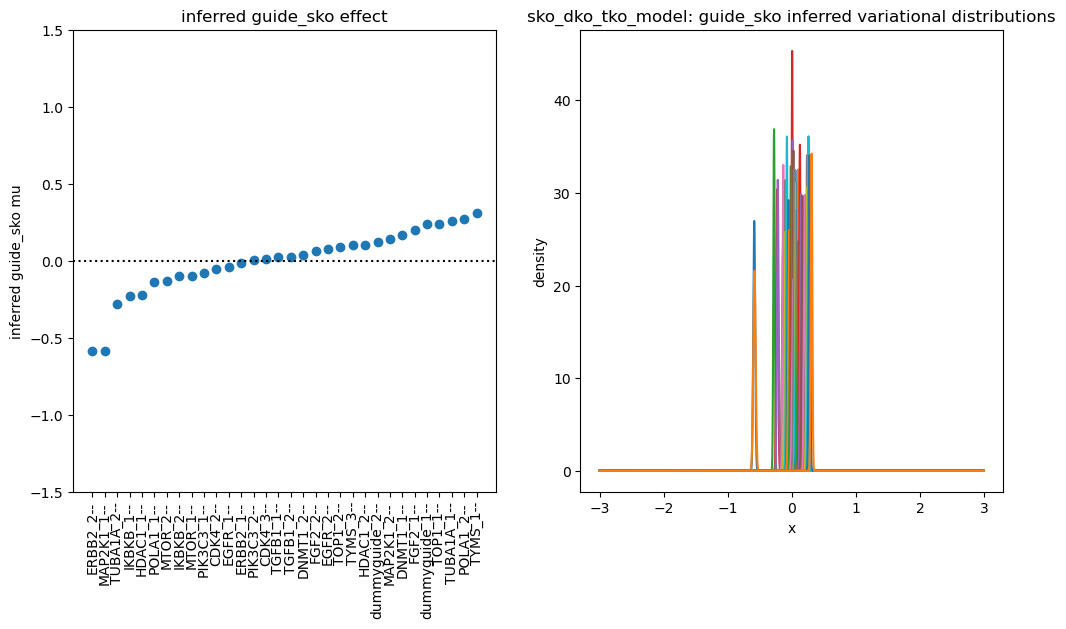

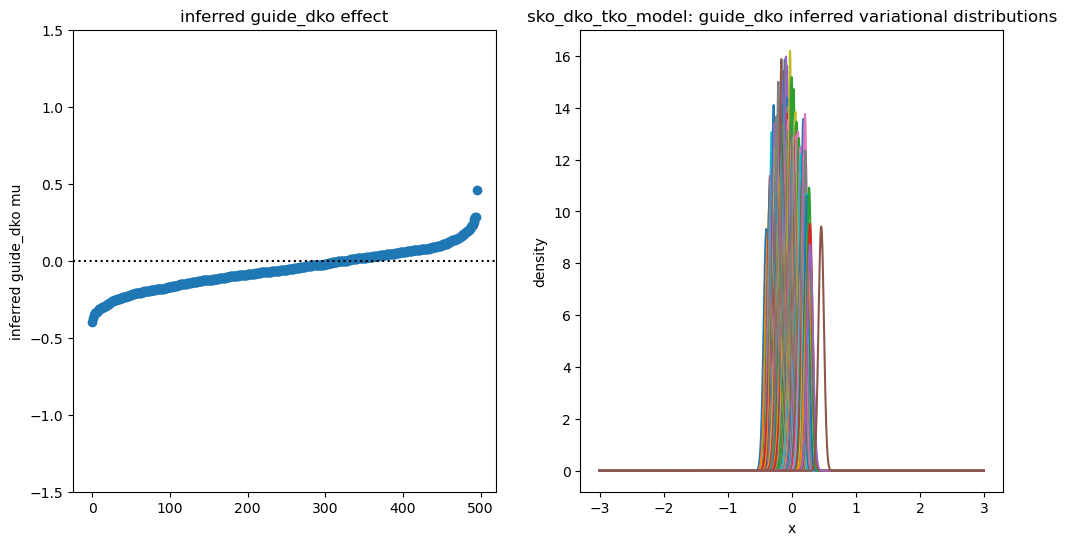

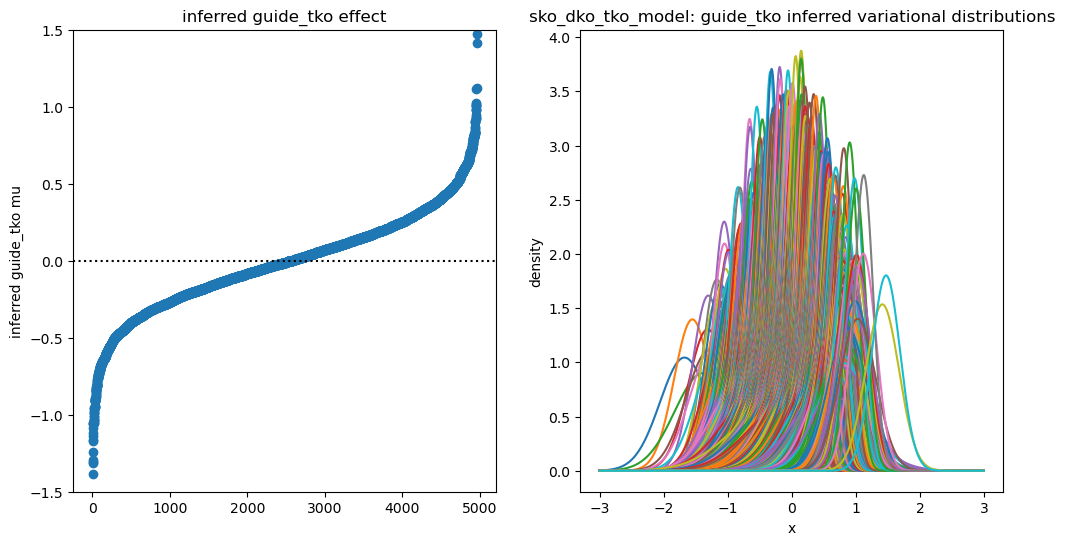

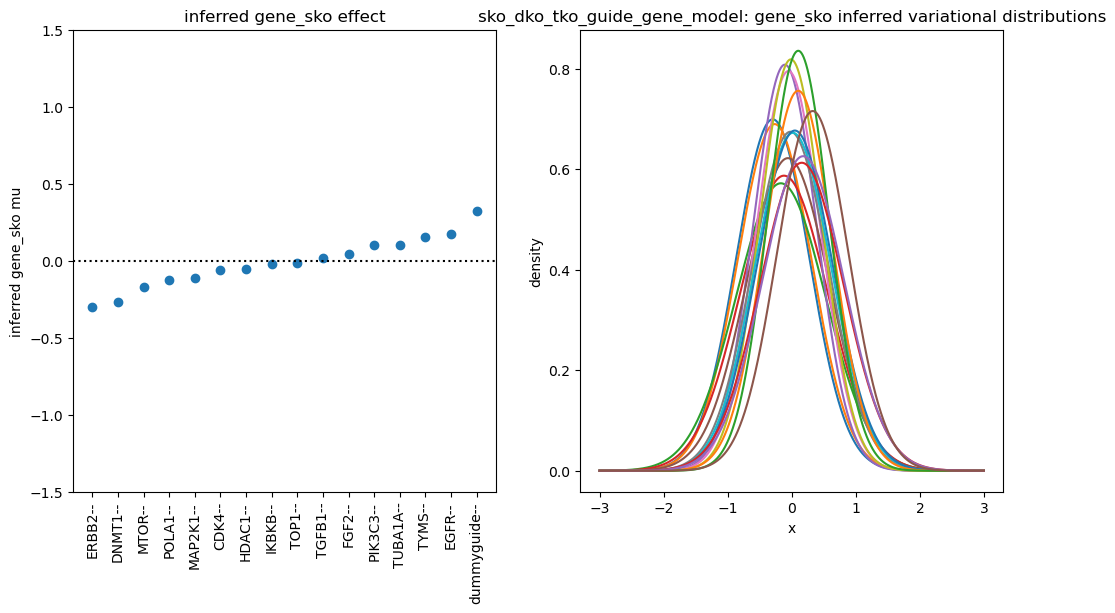

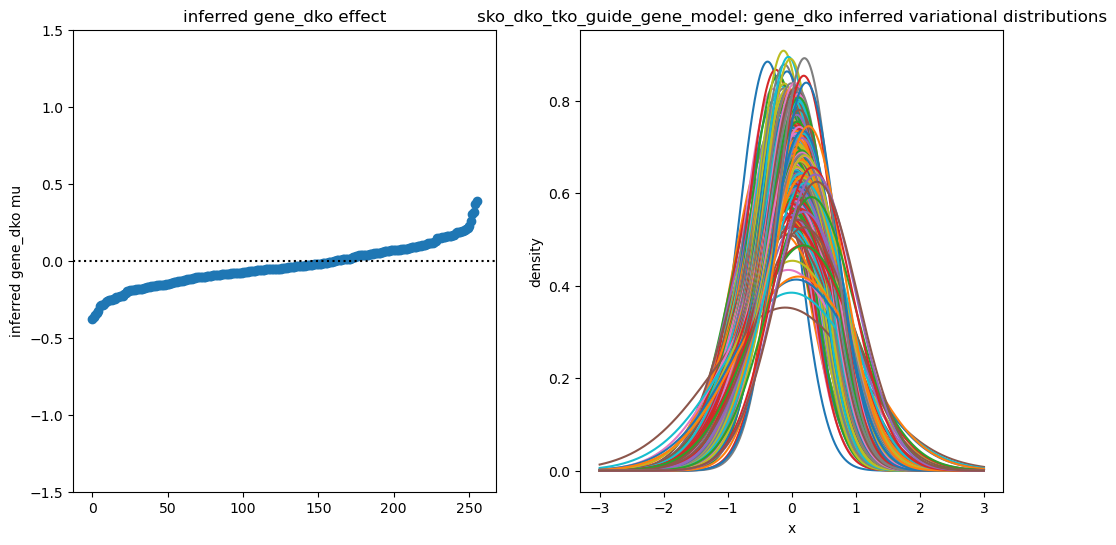

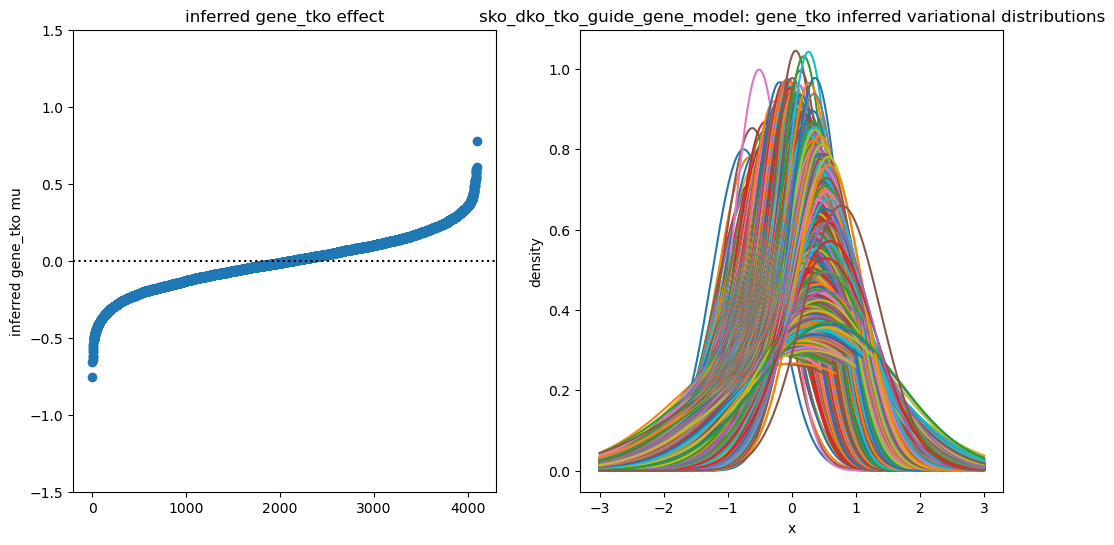

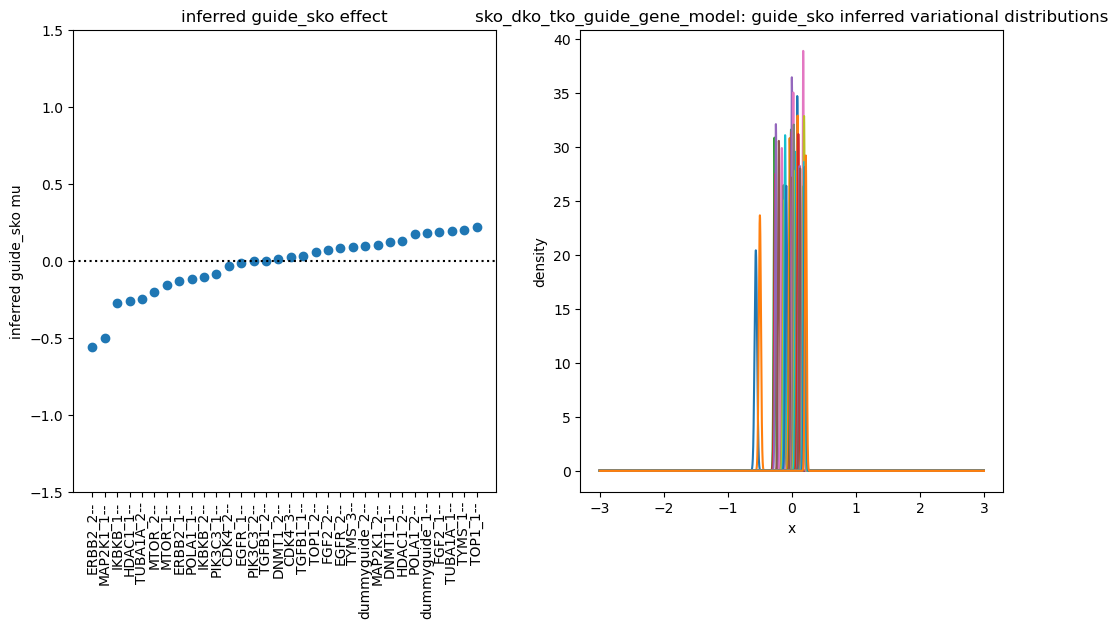

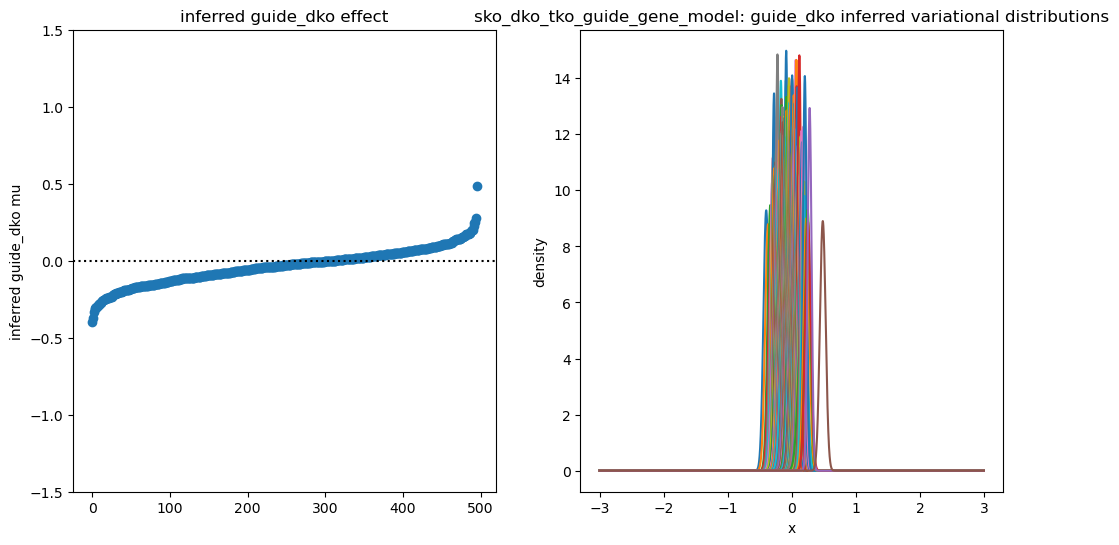

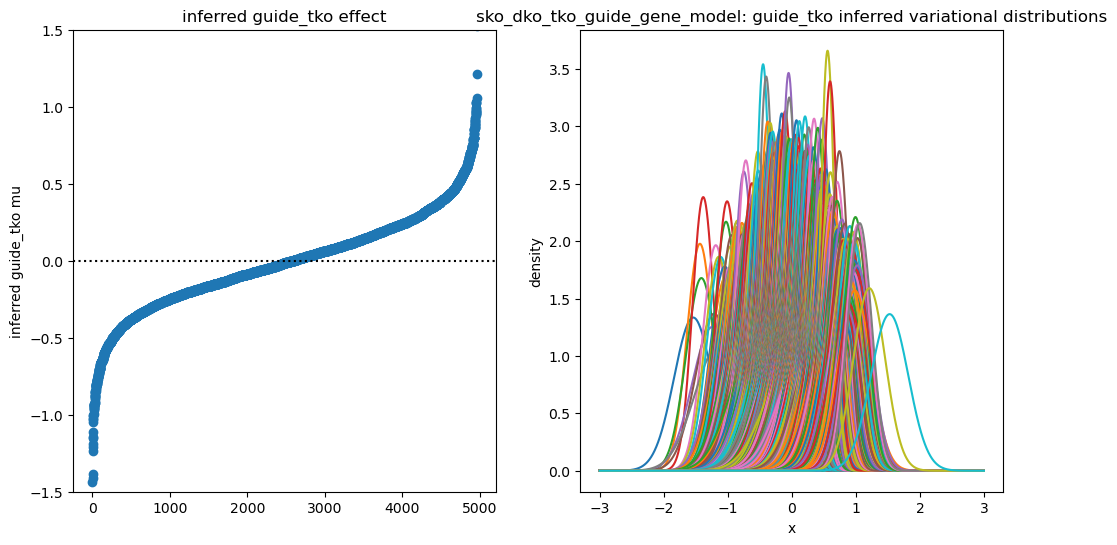

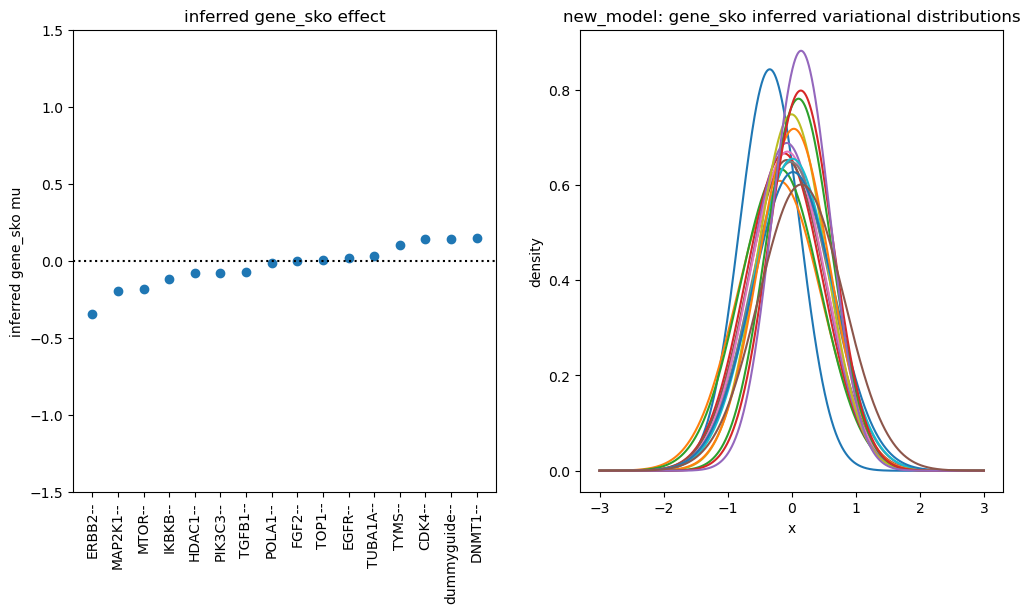

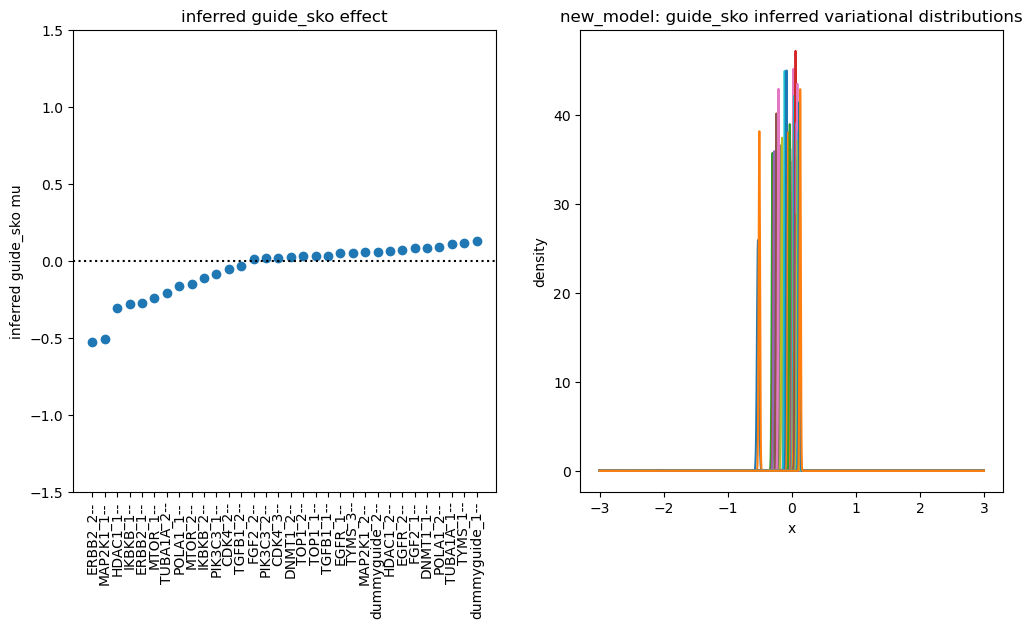

In [180]:
for model_name in outputs_dict:
    
    if model_name == 'sko_dko_model':
        continue
        
    effects_df = outputs_dict[model_name]['effects']
    images_path = f"images/{model_name}/"
        
    graph_inferred_mus_and_variational_distributions(effects_df, model_name, images_path)

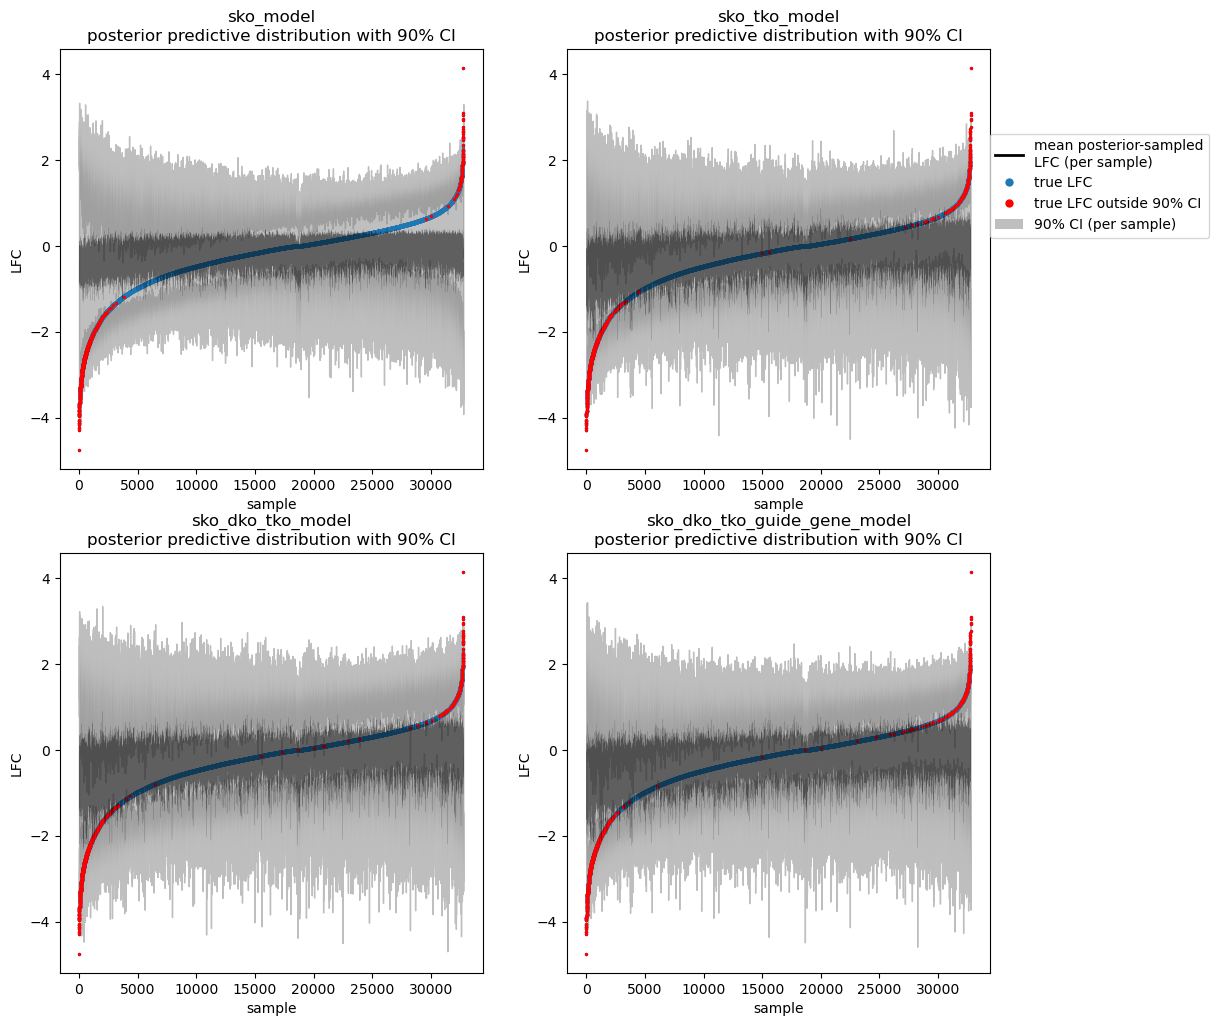

In [203]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i, model_name in enumerate(outputs_dict):
            
    if model_name == 'sko_dko_model':
        continue
        
    ax1, ax2 = (-1, -1)
    match i:
        
        case 0:
            ax1, ax2 = (0, 0)
            
        case 1:
            ax1, ax2 = (0, 1)
            
        case 2:
            ax1, ax2 = (1, 0)
            
        case 3:
            ax1, ax2 = (1, 1)
        
    lfc_predictions = outputs_dict[model_name]['predictions']
    outside_ci = lfc_predictions[(lfc_predictions['true_lfcs'] < lfc_predictions['y_perc_5']) | (lfc_predictions['true_lfcs'] > lfc_predictions['y_perc_95'])]

    ax[ax1, ax2].fill_between(lfc_predictions['y_perc_5'].index, lfc_predictions['y_perc_5'], lfc_predictions['y_perc_95'], alpha=0.5, color='grey')
    ax[ax1, ax2].plot(lfc_predictions['y_mean'].index, lfc_predictions['y_mean'].values, color='k',linewidth=0.1, alpha=0.5)
    ax[ax1, ax2].scatter(lfc_predictions['true_lfcs'].index, lfc_predictions['true_lfcs'].values, s=2)
    ax[ax1, ax2].scatter(outside_ci.index, outside_ci['true_lfcs'], color='red', s=2)

    ax[ax1, ax2].set_title(f"{model_name}\nposterior predictive distribution with 90% CI")
    ax[ax1, ax2].set_xlabel('sample')
    ax[ax1, ax2].set_ylabel('LFC')

legend_elements = [Line2D([0], [0], color='k', lw=2, label='mean posterior-sampled\nLFC (per sample)'),
                   Line2D([0], [0], marker='o', color='w', label='true LFC', markerfacecolor='#1f77b4', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='true LFC outside 90% CI', markerfacecolor='red', markersize=7),
                   Patch(facecolor='grey', alpha=0.5, label='90% CI (per sample)')]
plt.legend(handles=legend_elements, loc=(1, 1.75))

plt.savefig(f"images/all_posterior-predictions_vs_true_lfcs.png", dpi=300, bbox_inches='tight')
plt.show()